In [ ]:
# default_exp nb2bear

# nb2bear

> A package to convert a Jupyter notebook to a Bear page.̋

I use Jupyter notebooks for my data science projects. Bear is a general note-taking
 app that I prefer as my personal knowledge repository. While notebooks are
 excellent for exploration and development, it is easy to view them without
 starting a Jupyter server. So the intention of this tool is to format a Jupyter
 notebook into a Markdown document that gets properly rendered in Bear.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
# hide
from bs4 import BeautifulSoup
from fastcore.test import *
from nbconvert import MarkdownExporter
from urllib.request import urlopen
from urllib.parse import quote
from typing import Union

import bs4
import json
import markdown2
import nbformat
import os
import re

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

## Reading a notebook

We use a handful of regular expressions to format the contents of the notebook. In addition, this package includes the
`xcall` application which is used to call the x-callback URLs supported by Bear's API. The API token is needed to
delete any existing notes with the same title.

The regular expression for finding italics text comes with a caveat. The pattern `(\*)([^\s]*?)(\*)` (used earlier)
fails to identify italics text with whitespace. On the other hand, pattern `\*(?=\S)(.+?)(?<=\S)\*` (currently used)
fails for sentences like "Block comments start with `/*` and end with `*/`. It matches the content "*` and end with `*".

In [ ]:
# export
# italics_regex: re.Pattern = re.compile(r"(\*)([^\s]*?)(\*)")
italics_regex: re.Pattern = re.compile(r"\*(?=\S)(.+?)(?<=\S)\*")
bold_regex: re.Pattern = re.compile(r"(\*\*)([^\s]*?)(\*\*)")
header_regex: re.Pattern = re.compile(r"(#+)\s")
header_starts: tuple = ("# ", "## ", "### ", "#### ", "##### ", "###### ")
code_start: str = "```"
list_start: str = "* "
s4: str = " " * 4
indents: tuple = ("\t", s4)
quote_start: str = "> "
img_start: str = "!["
xcall_path: str = "./libs/xcall.app/Contents/MacOS/xcall"

The first step of the conversion is to convert the notebook to Markdown format using `nbconvert`. Usually used as
command line tool, we use it as a regular Python package. Following `nbconvert`'s tutorial
[Using nbconvert as a library](https://nbconvert.readthedocs.io/en/latest/nbconvert_library.html), we first load
(`load_notebook`) the Jupyter notebook which is a JSON. We then use the `nbformat` package to parse the notebook
(`parse_notebook`). This is followed by converting the notebook to Markdown (`convert_nb_to_markdown`) using the
`MarkdownExporter` class. Finally, we capture the base64 representations of all images in the notebook in a list which
is later used to reinsert the images after the rest of the notebook is formatted.

In [ ]:
# export
def load_nb(nb_fn: str) -> str:
    """Read a Jupyter notebook."""
    return urlopen(f"file://{nb_fn}").read().decode()

In [ ]:
# export
def parse_nb(nb_contents: str) -> nbformat.notebooknode.NotebookNode:
    """Convert a Jupyter notebook to a dictionary-like format."""
    return nbformat.reads(nb_contents, as_version=4)

In [ ]:
# export
def convert_nb_to_markdown(nb_contents: nbformat.notebooknode.NotebookNode) -> list:
    """Convert a Jupyter notebook to Markdown."""
    md_exporter = MarkdownExporter()
    nbc_out: str
    nbc_out, _ = md_exporter.from_notebook_node(nb_contents)

    return nbc_out.splitlines()

In [ ]:
# export
def get_nb_images(nb_contents: nbformat.notebooknode.NotebookNode) -> list:
    """Extract base64 representations of images in notebook."""
    nb_images: list = []
    for nb_cell in nb_contents.cells:
        if "attachments" not in nb_cell.keys():
            continue
        for _, attachment in nb_cell["attachments"].items():
            if "image/png" not in attachment.keys():
                continue
            img_base64: str = attachment["image/png"]
            nb_images.append(img_base64)

    return nb_images

In [ ]:
demo_nb_fp: str = os.path.abspath("../assets/demo.ipynb")
demo_nb_raw: str = load_nb(demo_nb_fp)
demo_nb_parsed: nbformat.notebooknode.NotebookNode = parse_nb(demo_nb_raw)
demo_md: list = convert_nb_to_markdown(demo_nb_parsed)

In [ ]:
demo_nb_imgs: list = get_nb_images(demo_nb_parsed)

## Formatting notebook contents

Prior to version 2.0, the default markup syntax in Bear was the *Polar Bear Markup Language*. It is similar to
the traditional Markdown syntax with two notable differences:
* Italics text is placed between `/ /` instead of `* *`.
* Bold text is placed between `* *` instead of `** **`.

Identifying italics and bold text in Markdown is tricky. For example, bullets in Markdown can start with `*`. Also,
regular text or code can contain `*` like `/* */` for comments in certain languages.

So the regular expression we use do not allow for whitespace between `*` pairs. Thus, `*this*` will be a match but
`*this won't*` be.

In [ ]:
# export
def convert_to_pb_markup(line: str) -> str:
    """Transform specific Markdown syntax to compatible Polar Bear markup."""
    line = italics_regex.sub(r"/\1/", line)
    line = bold_regex.sub(r"\*\1\*", line)

    return line

In [ ]:
italics_ex_1: str = "* *Receiver Functions* are associated with a specific type."
test_eq(convert_to_pb_markup(italics_ex_1), "* /Receiver Functions/ are associated with a specific type.")

italics_ex_2: str = "* Go is a *statically-typed* language."
test_eq(convert_to_pb_markup(italics_ex_2), "* Go is a /statically-typed/ language.")

The Markdown content is processed and format line by line as the contents of the previous line inform decisions in
the current line. The first line, which is assumed to be the title of the document, is copied as is. For subsequent
lines, checks and modifications include:
* Skip the line if empty.
* For header lines, add an empty line above if the previous line is neither empty, nor a quoted line.
* If the line is indented:
    * Add a `> ` at the beginning if the previous line starts with `> `.
    * Add a `> ` at the beginning, and an empty line before it if the previous line is the end of a code block.
* In the exported Markdown, indentations are represented as a collection of whitespaces. We convert them to tabs (`\t`)
so that they are rendered correctly in Bear.
* If the previous line starts with `> ` but not the current line (thus marking the end of code block output), add an
empty line.

In [ ]:
# export
def are_empty(lines: list) -> bool:
    return all([(not x) for x in lines])

def is_header(line: str) -> bool:
    return bool(re.match(header_regex, line))

def is_indented(line: str) -> bool:
    return line.startswith(indents)

def is_code_marker(line: str) -> bool:
    return line.startswith(code_start)

def is_empty_line_after_header(line, last_line) -> bool:
    return is_header(last_line) and (not line)

def quote_if_code_output(line, last_two_lines) -> str:
    if (not last_two_lines[-1]) and is_code_marker(last_two_lines[-2]):
        return f"> {line}"
    else:
        return line

In [ ]:
# export
def format_markdown(contents: list) -> str:
    """Format Jupyter exported Markdown to Bear-compatible format."""
    formatted_contents: list = [contents[0]]
    line: str
    for line in contents[1:]:
        last_line: str = formatted_contents[-1]
        last_two_lines: list = formatted_contents[-2:]

        # Skip more than one empty line.
        if are_empty([line, last_line]): continue
        if is_empty_line_after_header(line, last_line): continue

        if is_indented(line):
            line = quote_if_code_output(line, last_two_lines)

        line = convert_to_pb_markup(line)
        formatted_contents.append(line)

    return "\n".join(formatted_contents)

In [ ]:
demo_formatted_md: str = format_markdown(demo_md)

## Converting to HTML

*Note: Embedded images in a notebook cannot be automatically added to a Bear page currently. Bear developers might
support this feature at a later date. Till then, we need to manually copy all our images from the notebook to Bear.*

When the notebook contains embedded images and we wish them to be automatically integrated in a Bear note, we need to
convert the Markdown contents to HTML (`convert_md_to_html`). Then, the images extracted previously are put back in
their respective positions (`embed_images`).

There are differences in how Bear imports HTML and Markdown content. They include:
* Imported HTML contains lots of whitespace. 
* Images cannot be embedded using Markdown text.

An image can be imported into Bear using a JPEG/PNG file or a base64 representation. As Mac apps are sandboxed, Bear
cannot get access to locations on the hard drive where the image files might be stored. And the `/create` action of
Bear's API which is used to create the note does not support images in base64 format. Bear developers might add this
support at a later date. To follow up on the development, check the reddit thread
[Embed images in a note using x-callback](https://www.reddit.com/r/bearapp/comments/l36uw3/embed_images_in_a_note_using_xcallback/gkxnx7r/?context=3).

In [ ]:
# export
def convert_markdown_to_html(contents: list) -> str:
    """Wrap markdown text in HTML tags."""
    md: str = "\n".join(contents)
    return markdown2.markdown(md, extras=["fenced-code-blocks", "cuddled-lists"])

In [ ]:
# export
def add_images_to_html(html: str, imgs: list) -> str:
    """Embed images in base64 representation. (Currently not supported by Bear)"""
    html_soup: BeautifulSoup = BeautifulSoup(html)
    for i, img in enumerate(html_soup.findAll("img")):
        img["src"] = f"data:image/png;base64, {imgs[i]}"

    return str(html_soup)

In [ ]:
demo_formatted_html: str = convert_markdown_to_html(demo_formatted_md)
demo_html_with_images: str = add_images_to_html(demo_formatted_html, demo_nb_imgs)

## Add to Bear

If we add our notebooks to Bear incrementally, it makes sense to delete (i.e. move to *Trash*) the existing note. We
currently delete an existing note if its title exactly matches the title of the notebook. Thus, based on whether the
content sent to Bear is Markdown or HTML, we first get its title (`get_nb_title`).

In [ ]:
# export
def get_nb_title(text: str) -> str:
    """Get note title."""
    heading: Union[bs4.element.Tag, None] = BeautifulSoup(text, "html.parser").h1
    if heading is None:
        # Content is markdown, assume the first line to be the heading.
        return re.sub(header_regex, "", text.splitlines()[0])
    else:
        return heading.string

In [ ]:
test_eq(get_nb_title(demo_formatted_md), "Demo")
test_eq(get_nb_title(demo_formatted_html), "Demo")

In [ ]:
go_fundamentals_title: str = get_nb_title(demo_formatted_md)

In [ ]:
# export
def trash_existing_note(title: str, api_token: str):
    """Delete an existing note with the same title to avoid duplicates."""
    search_output: dict = json.loads(os.popen(f"{xcall_path} -url 'bear://x-callback-url/search?term={quote(title)}"
                                              f"&show_window=no&token={api_token}'").read())
    current_notes: list = json.loads(search_output["notes"])
    note: dict
    for note in current_notes:
        if note["title"] == title:
            note_id: str = note["identifier"]
            os.popen(f"{xcall_path} -url 'bear://x-callback-url/trash?show_window=no&id={note_id}'")

A note can be added to Bear using the `x-callback-url` API. To the `/create` action of this API, we supply the body
of the note (as the `text` argument) with the contents 'quoted' i.e. special characters except `_.-~` replaced with
`%xx` escapes. For instance, whitespace is replaced by `%20`. 

If we prefer whitespaces in our note, the value for mode should be `comfortable`. In this case, the (formatted) HTML version of the notebook is sent to Bear with the right parameters (`type=html&url=`). The default mode is `compact` which retains just enough whitespace to keep the note content legible.

In [ ]:
# export
def add_to_bear(text: str, api_token: str, layout: str = "compact"):
    """Create a new Bear note."""
    title: str = get_nb_title(text)
    trash_existing_note(title, api_token)
    if layout == "comfortable":
        os.system(f"{xcall_path} -url 'bear://x-callback-url/create?type=html&url=&text={quote(text)}'")
    else:
        os.system(f"{xcall_path} -url 'bear://x-callback-url/create?text={quote(text)}'")

In [ ]:
bear_api_token: str = "D11B63-D71E64-DE9400"

In [ ]:
add_to_bear(demo_formatted_md, bear_api_token)

## Running in console

If running `nb2bear` in a Python console, the function `convert_nb_to_bear` does the job. The following screenshots
show the difference between `compact` and `comfortable` layout.

Compact layout|Comfortable layout 
-|-
![compact](images/compact.png)|![comfortable](images/comfortable.png)
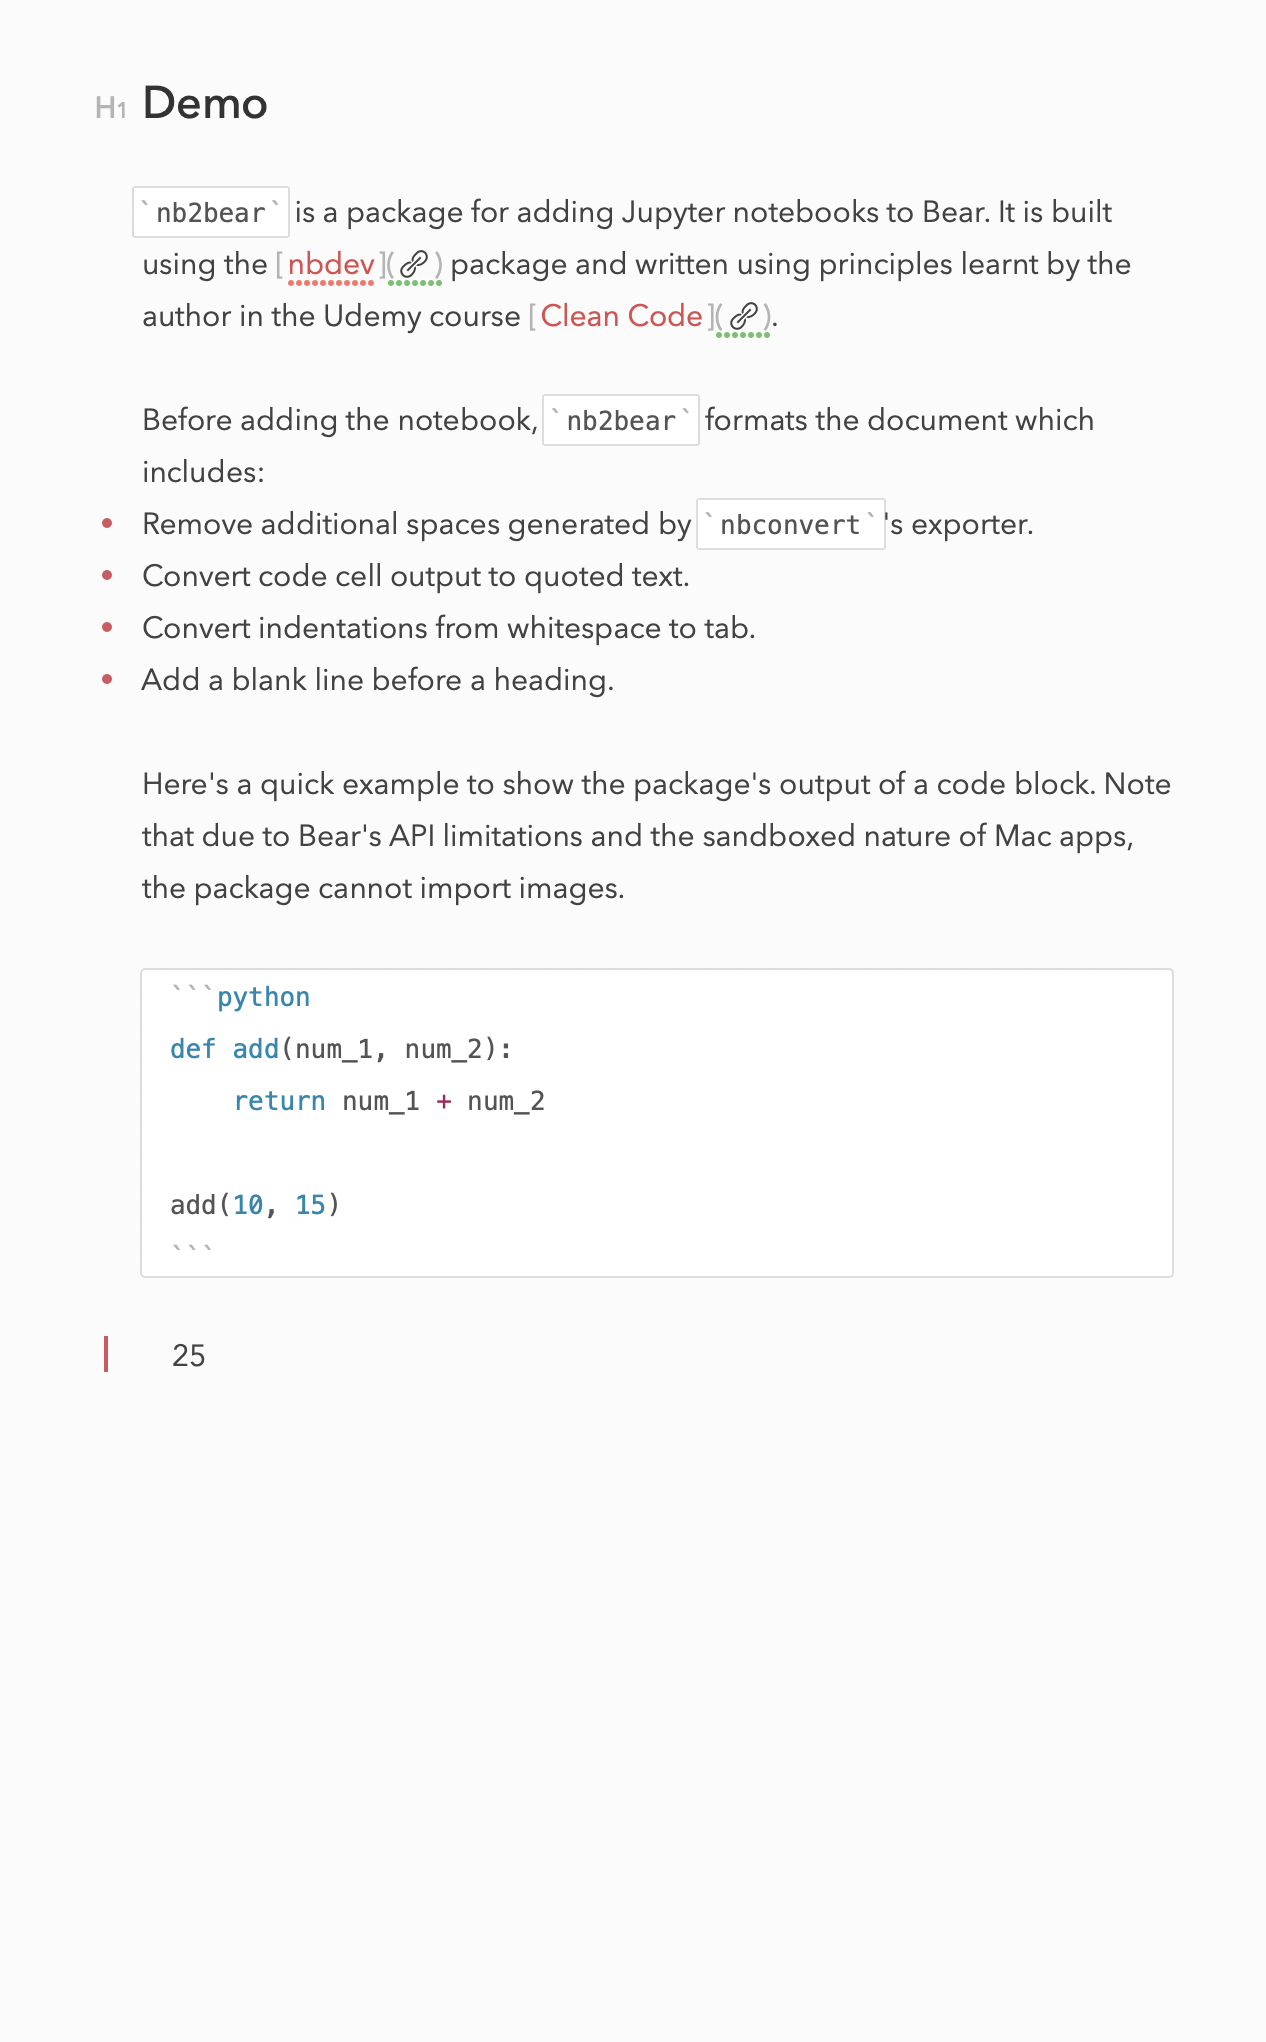
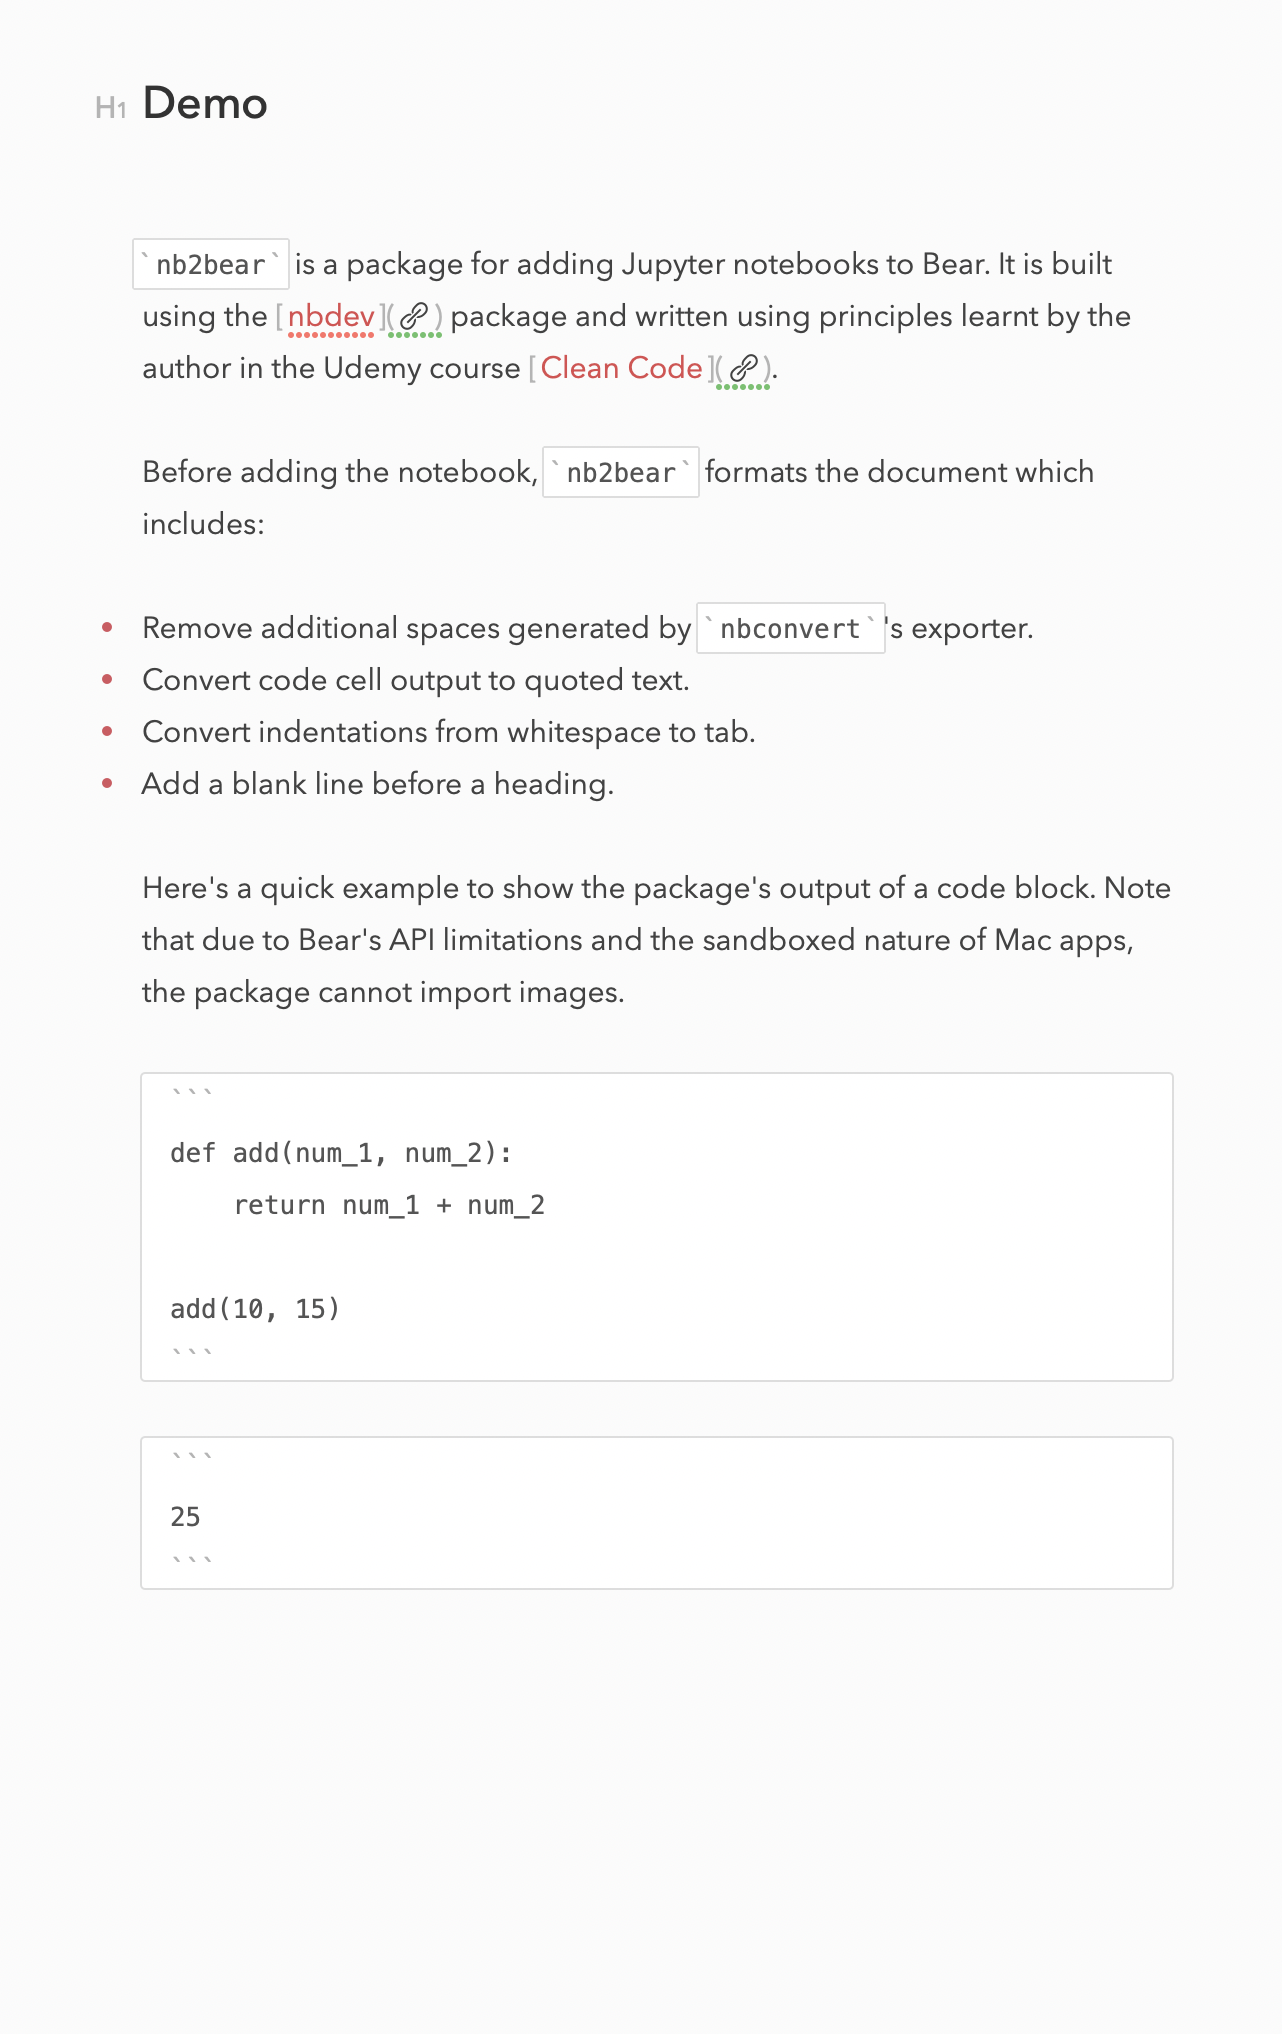

In [ ]:
# export
def convert_nb_to_bear(nb_fn: str, api_token: str, layout: str = "compact"):
    """Convert a Jupyter notebook to a Bear page."""
    nb_raw: str = load_nb(nb_fn)
    nb_parsed: nbformat.notebooknode.NotebookNode = parse_nb(nb_raw)
    md_text: list = convert_nb_to_markdown(nb_parsed)
    if layout == "comfortable":
        nb_imgs: list = get_nb_images(nb_parsed)
        formatted_html: str = convert_markdown_to_html(md_text)
        html_with_images: str = add_images_to_html(formatted_html, nb_imgs)
        add_to_bear(html_with_images, api_token, layout)
    else:
        formatted_md: str = format_markdown(md_text)
        add_to_bear(formatted_md, api_token)

In [ ]:
# convert_nb_to_bear(demo_nb_fp, bear_api_token)
convert_nb_to_bear(demo_nb_fp, bear_api_token, "comfortable")

## Command line interface

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_nb2bear.ipynb.
Converted index.ipynb.
